--------------------------------------------------------------

## **Bayesian Deep Learning & Estimating Uncertainty**

--------------------------------------------------------------

Performances of Deep Neural Networks (DNNs) rely on the ability to progressively build and extract features from large data. Though these deep models are usually adaptive the performance depends on the data distribution. The robustness property is important in various applications such as computer vision tasks, eg. autonomous driving, because the outdoor environments may naturally vary. One thing at this point we would desire is to **know how likely the predictions are going to be correct, and this can be done by incorporating uncertainty estimation within the model**.

For this example, we have created synthetic data and built simple linear models to find not only the best models but also the corresponding uncertainty estimations.

Useful resources:
1. [Aleatoric and epistemic uncertainty in machine learning: an introduction to concepts and methods](https://link.springer.com/article/10.1007/s10994-021-05946-3). 
2. [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977).
3. [Bayesian Deep Learning & Estimating Uncertainty](https://towardsdatascience.com/bayesian-deep-learning-estimating-uncertainty-9907f5208cc0)
4. [Aleatoric and Epistemic Uncertainty in Deep Learning
](https://towardsdatascience.com/aleatoric-and-epistemic-uncertainty-in-deep-learning-77e5c51f9423)
5. [Uncertainty Quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification)

One of the easiest to ways to get started with different types of uncertainties is to think about reducible and irreducible uncertainties.

**_Aleatoric (aka Statistical) Uncertainty_:** *captures noise inherent in the observations*. This could be for example sensor noise or motion noise, resulting in uncertainty **which cannot be reduced** even if more data were to be collected. 

**_Epistemic (aka Systematic) Uncertainty_:** *accounts for uncertainty in the model parameters*. This uncertainty captures insufficiency or ignorance/negligence about certain aspects in our collected data. This uncertainty **can be explained away given enough data**, and is often referred to as model uncertainty.

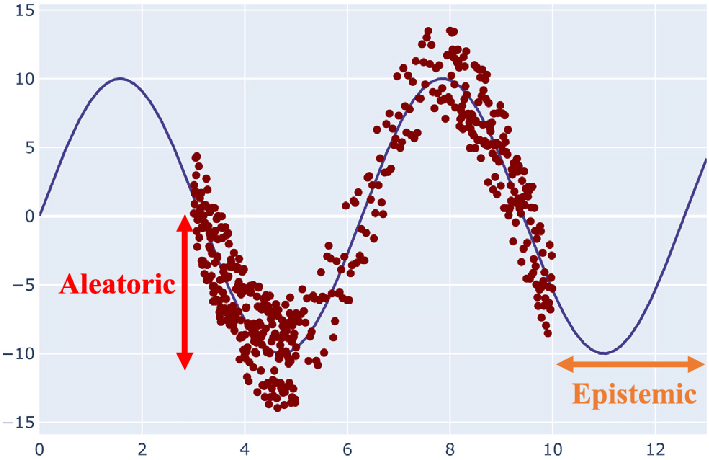

**These uncertainties are formalized as probability distributions over either the model parameters (for Epistemic Uncertainty), or model outputs (for Aleatoric Uncertainty).** Epistemic uncertainty is modeled by placing a prior distribution over a model’s weights, and then trying to capture how much these weights vary given some data. Aleatoric uncertainty on the other hand is modeled by placing a distribution over the output of the model. 

--------------------------------------------------------------

## **Bayesian Neural Networks (BNNs) - Capturing Uncertainty**

--------------------------------------------------------------

**To capture epistemic uncertainty** in a neural network $(NN)$ we put a prior distribution over its weights, for example a Gaussian prior distribution: $W ∼ \mathcal{N} (0, I)$.

Such a model is referred to as a *Bayesian Neural Network (BNN)*. Bayesian neural networks **replace the deterministic network’s weight parameters with distributions over these parameters, and instead of optimising the network weights directly, we average over all possible weights** (referred to as marginalization). Denoting the random output of the BNN as $f^{W}(x)$, we define the model likelihood $p\left(y|f^{W}(x)\right)$. Given a dataset $X = \{x_1, ..., x_N\},\, Y=\{y_1,\, \ldots , y_N\}$, Bayesian inference
is used to compute the posterior over the weights $p(W|X, Y)$. This posterior captures the set of plausible model parameters, given the data. For regression tasks we often define our likelihood as a Gaussian with mean given by the model
output: $p(y|f^{W}(x)) = \mathcal{N} \left(f^W(x), \sigma^2\right)$, with an observation noise scalar parameter $\sigma$.

BNNs are are easy to formulate, but difficult to perform inference in. This is because the marginal probability $p(Y|X)$ required to evaluate the posterior $p(W|X, Y)= \frac{p(Y|X,W) \cdot p(W)}{p(Y|X)}$ cannot be evaluated analytically. However, different methods exist to capture epistemic uncertainty (model parameter uncertainty), by approximating the distribution $p(W|X, Y)$.

---

**To capture aleatoric uncertainty** in regression, we would have to tune the observation noise parameter $σ$. **Homoscedastic regression** assumes constant observation noise $\sigma$ for every input point $x$. **Heteroscedastic regression**, on the other hand, assumes that observation noise can vary with input $x$. Heteroscedastic models are useful in cases where parts of the observation space might have higher noise levels than others.

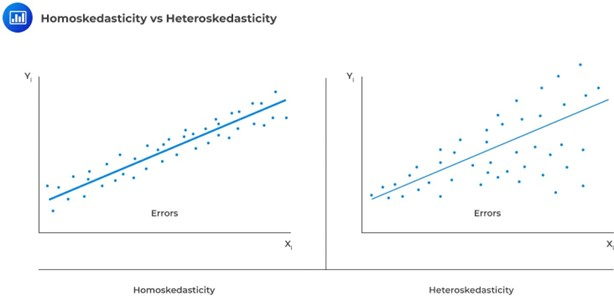

------------------------------------------------------

### **_Dataset_**
Here, we create some randomized data resembling a linear relationship. The orange dots represent only 10% (partial) of the full data. In the following, we will train the same models on both the “full dataset” and the “partial dataset”, to see if adding more data will help reduce different kinds of uncertainty.

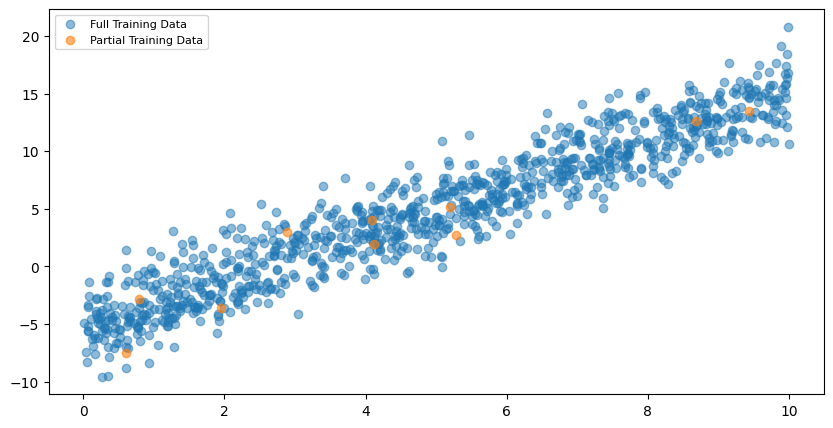

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
def load_dataset(): 
  rng = np.random.RandomState(22)
  x = 10 * rng.rand(1000)
  y = 2 * x - 5 + 2*rng.randn(1000)
  x = x.reshape(-1, 1)
  y = y.reshape(-1, 1)
  x_partial = 10 * rng.rand(10)
  y_partial = 2 * x_partial - 5 + 2*rng.randn(10)
  return  x.reshape(-1, 1), y.reshape(-1, 1), x_partial.reshape(-1, 1), y_partial.reshape(-1, 1)

x, y, x_partial, y_partial = load_dataset()

# Set figure size
plt.figure(figsize=(10, 5))
# Plot training data
plt.scatter(x, y, label="Full Training Data", alpha=0.5) # Full data
plt.scatter(x_partial, y_partial, label="Partial Training Data", alpha=0.6) # Partial data
# Add legend and show the plot
plt.legend(prop={'size': 8})
plt.show()

### **Uncertainties Inherent in the Data (Aleatoric Uncertainty)**
The model contains only two layers, one classic Dense layer that has two output neurons used as mean and standard deviation values for the following DistributionLambda layer.

We train the model on both the whole dataset and the dataset with fewer points (orange dots in the plot above) and obtain the following result. We can notice at once that the models trained on different datasets result in a similar predictions and adding more data does not reduce the aleatoric uncertainty.

In [20]:
import tensorflow as tf 
import tensorflow_probability as tfp
tfd = tfp.distributions # Probability distributions
negloglik = lambda y, rv_y: -rv_y.log_prob(y) # Negative log-likelihood loss

Defining the models

In [21]:
# Define model to be trained on full data
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1), # Dense layer
  tfp.layers.DistributionLambda( # DistributionLambda layer
      lambda t: tfd.Normal(loc=t[..., :1], # Mean (location)
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))), # Standard deviation (scale)
])

# Define model to be trained on partial data 
model_partial = model

Training the models

In [22]:
# Compile the models
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model_partial.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

# Fit the data
model.fit(x, y, epochs=1000, verbose=False)
model_partial.fit(x_partial, y_partial, epochs=1000, verbose=False)

Testing the models

In [23]:
# Generate test data
rng = np.random.RandomState(22)
x_tst = 10 * rng.rand(100)

# Test the models using test data
y_hat = model(x_tst)
y_partial_hat = model_partial(x_tst)

Analysing the models

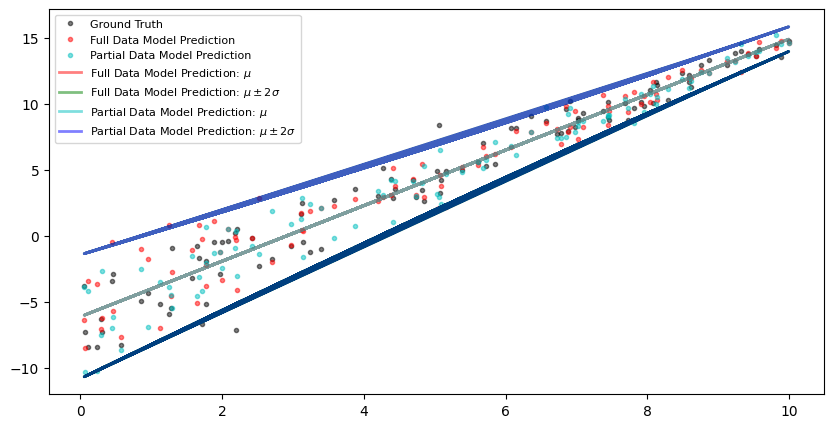

In [24]:
# Set figure size
plt.figure(figsize=(10, 5))
# Plot test data ground truth
plt.plot(x_tst, y_hat.sample(), 'k.', label='Ground Truth', alpha=0.5);
# Plot model predictions
plt.plot(x_tst, y_hat.sample().numpy(), 'r.', linewidth=4, label='Full Data Model Prediction', alpha=0.5);
plt.plot(x_tst, y_partial_hat.sample().numpy(), 'c.', linewidth=4, label='Partial Data Model Prediction', alpha=0.5);
# Compute mean and standard deviation of model predictions
m = y_hat.mean()
s = y_hat.stddev()
m_partial = y_partial_hat.mean()
s_partial = y_partial_hat.stddev()
# Plot uncertainty of model trained on full data
plt.plot(x_tst, m, 'r', linewidth=2, label='Full Data Model Prediction: $\mu$', alpha=0.5);
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label='Full Data Model Prediction: $\mu \pm 2 \sigma$', alpha=0.5);
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2);
# Plot uncertainty of model trained on partial data
plt.plot(x_tst, m_partial, 'c', linewidth=2, label='Partial Data Model Prediction: $\mu$', alpha=0.5);
plt.plot(x_tst, m_partial + 2 * s_partial, 'b', linewidth=2, label=r'Partial Data Model Prediction: $\mu \pm 2 \sigma$', alpha=0.5);
plt.plot(x_tst, m_partial - 2 * s_partial, 'b', linewidth=2, alpha=0.5);
# Add legend and show the plot
plt.legend(prop={'size': 8})
plt.show()

### **Uncertainties in Weights of the Model (Epistemic Uncertainty)**
Different from what we did before, the model here contains a DenseVariational layer. This layer uses variational inference to fit a posterior to the distribution over both the kernel matrix and the bias terms which are otherwise used like a Dense layer. The variational inference is an alternative to the Markov chain Monte Carlo (MCMC) to approximate the posterior distribution in machine learning.

As before, we train the model on both the full dataset and the partial dataset with fewer points. We notice in the plot below that the standard deviation is smaller when we train the model on a bigger dataset. In another words, this example shows that more data can reduce epistemic uncertainty.



Defining the models

In [25]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Define model to be trained on full data
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Define model to be trained on partial data
model_partial=model

Training the models

In [26]:
# Compile the models
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model_partial.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

# Fit the data
model.fit(x, y, epochs=1000, verbose=False)
model_partial.fit(x_partial, y_partial, epochs=1000, verbose=False)

Testing the models

In [27]:
# Generate test data
rng = np.random.RandomState(22)
x_tst = 15 * rng.rand(100)

# Test the models using test data
y_hat = model(x_tst)
y_partial_hat = model_partial(x_tst)

Analysing the models

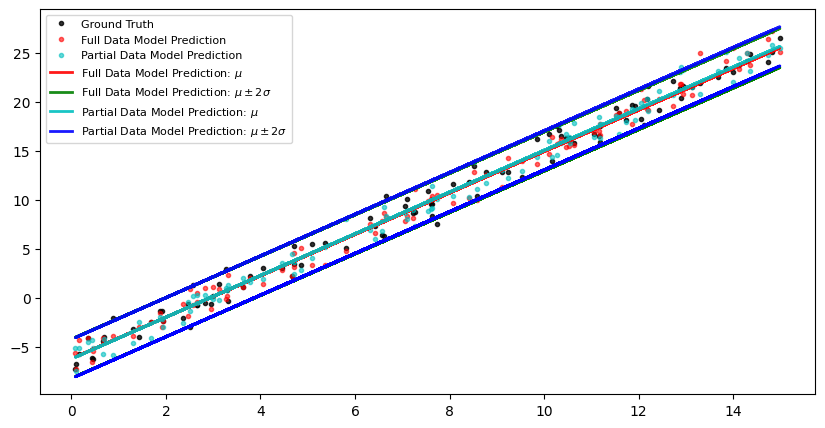

In [28]:
# Set figure size
plt.figure(figsize=(10, 5))
# Plot test data ground truth
plt.plot(x_tst, y_hat.sample(), 'k.', label='Ground Truth', alpha=0.8);
# Plot model predictions
plt.plot(x_tst, y_hat.sample().numpy(), 'r.', linewidth=4, label='Full Data Model Prediction', alpha=0.6);
plt.plot(x_tst, y_partial_hat.sample().numpy(), 'c.', linewidth=4, label='Partial Data Model Prediction', alpha=0.6);
# Compute mean and standard deviation of model predictions
m = y_hat.mean()
s = y_hat.stddev()
m_partial = y_partial_hat.mean()
s_partial = y_partial_hat.stddev()
# Plot uncertainty of model trained on full data
plt.plot(x_tst, m, 'r', linewidth=2, label='Full Data Model Prediction: $\mu$', alpha=0.9);
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label='Full Data Model Prediction: $\mu \pm 2 \sigma$', alpha=0.9);
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2);
# Plot uncertainty of model trained on partial data
plt.plot(x_tst, m_partial, 'c', linewidth=2, label='Partial Data Model Prediction: $\mu$', alpha=0.9);
plt.plot(x_tst, m_partial + 2 * s_partial, 'b', linewidth=2, label=r'Partial Data Model Prediction: $\mu \pm 2 \sigma$', alpha=0.9);
plt.plot(x_tst, m_partial - 2 * s_partial, 'b', linewidth=2);
# Add legend and show the plot
plt.legend(prop={'size': 8})
plt.show()

### **Uncertainties in Data & Model Weights (Aleatropic & Epistemic Uncertainties)**

We can put the two kinds of uncertainty estimations in one single model by combining the DenseVariational layer with the DistributionLambda layer as discussed earlier separately.

Defining the model

In [ ]:
# Define model
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

Training the model

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik) # Compile the models
model.fit(x, y, epochs=1000, verbose=False) # Fit the data

Testing the model

In [ ]:
# Generate test data
rng = np.random.RandomState(0)
x_tst = 10 * rng.rand(150)

# Test the models using test data
y_hat = model(x_tst)
y_partial_hat = model_partial(x_tst)

Analysing the model

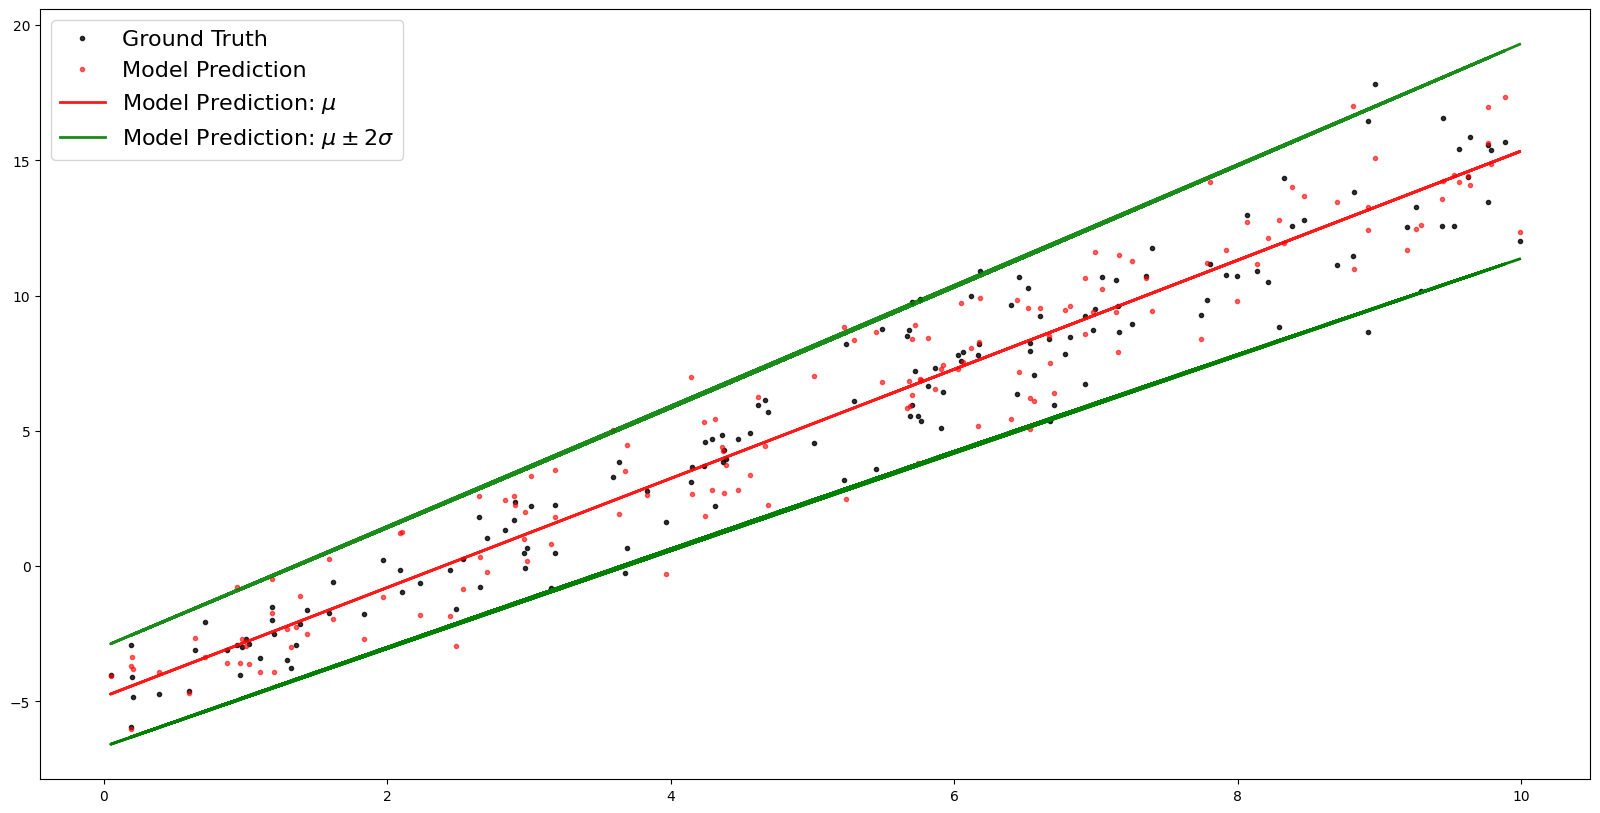

In [ ]:
# Set figure size
plt.figure(figsize=(10, 5))
# Plot test data ground truth
plt.plot(x_tst, y_hat.sample(), 'k.', label='Ground Truth', alpha=0.8);
# Plot model predictions
plt.plot(x_tst, y_hat.sample().numpy(), 'r.', linewidth=4, label='Model Prediction', alpha=0.6);
# Compute mean and standard deviation of model predictions
m = y_hat.mean()
s = y_hat.stddev()
# Plot uncertainty of model
plt.plot(x_tst, m, 'r', linewidth=2, label='Model Prediction: $\mu$', alpha=0.9);
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label='Model Prediction: $\mu \pm 2 \sigma$', alpha=0.9);
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2);
# Add legend and show the plot
plt.legend(prop={'size': 8})
plt.show()